In [10]:
! pwd
! pip uninstall sympytorch -y

/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning


Found existing installation: sympytorch 0.1.4
Uninstalling sympytorch-0.1.4:
  Successfully uninstalled sympytorch-0.1.4


In [1]:
import os
import sys


#ROOT="/home/guillermo.carrilho/PhysicsSimulationDeepLearning"
ROOT="/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning"

sys.path.append(os.path.join(ROOT,"Physical_models"))

# stable difusion approach

In [38]:
from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *


geo=UniformGrid(x=500, y=500,bounds=Box(x=5e3, y=5e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':4e3,
          'x+': 4e3,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phi_o=Field( geo,values=tensor(1142.0),
      boundary= {
          'x-': 2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phy=two_phase_flow(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
    #w_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v),
    w_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v),
    #o_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v)
    o_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v)
)

from Differentiable_simulation import K_o_f_t,K_w_f_t,S_w,dK_o,dK_w,dK_o,dsdpc
#from Differentiable_simulation import *
#dsdpc=(lambda p_c:math.clip((-1*LAMBDA)*((S_w(p_c)-SWR)/PD),lower_limit=1e-6))
import anisotropic_diffusion
print(phy.compute_p_c(phi_w,phi_o))
print(S_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w_f_t(S_w(phy.compute_p_c(phi_w,phi_o))))
print(dsdpc(phy.compute_p_c(phi_w,phi_o)))

print(dK_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w(phy.compute_p_c(phi_w,phi_o)))
print(phy.compute_convective_velocity(phi_o,phi_w,dK_w,dK_o).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(phi_w,phi_o)))
print(dK_o(phy.compute_p_c(phi_w,phi_o)))
#print(phy.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o).sample(phi_o.geometry))
print(phy.phi_w_momentum_eq(phi_w,phi_o, 1e-4).sample(phi_o.geometry))

PD=2e3
SWR=0.3
SOR=0.1
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.3))
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.7))

(xˢ=500, yˢ=500) const 1142.0
(xˢ=500, yˢ=500) const 0.8999999761581421
(xˢ=500, yˢ=500) const 0.049999989569187164
(xˢ=500, yˢ=500) const 9.999999974752427e-07
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 0.083 ± 0.083 (0e+00...2e-01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 2.50e+04 ± 2.5e+04 (0e+00...5e+04)
(xˢ=500, yˢ=500, vectorᶜ=x,y) -0.007 ± 0.226 (-7e+00...0e+00)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 3.49e-21 ± 3.5e-21 (0e+00...7e-21)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 5.47e-19 ± 5.5e-19 (0e+00...1e-18)


Diverged: Solve diverged within 891 iterations using Φ-ML CG (PyTorch*)

In [ ]:
import matplotlib.pyplot as plt

class two_phase_flow(object):
  def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt,w_advection_solver,o_advection_solver):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dtphi_o_1=dtphi_o_1
    self.dtphi_w_1=dtphi_w_1
    self.dt=dt
    self.p=None
    self.w_advection_solver=w_advection_solver
    self.o_advection_solver=o_advection_solver


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_o.sample(phi_o.geometry) -\
    phi_w.sample(phi_w.geometry)
    return p_c

  def compute_convective_velocity(self,phi_a,phi_b,dK_a,dK_b):
    p_c=self.compute_p_c(self.phi_w,self.phi_o)
    convective_velocity = grad_phi_dK(phi_a,dK_a(p_c))\
                         - grad_phi_dK(phi_b,dK_b(p_c))

    V=unstack(convective_velocity,"dk")
    convective_velocity=Field(self.phi_o.geometry,values=vec(x=V[0],y=V[1]))
    return convective_velocity

  #def compute_anisotropic_viscosity_effect(self):
    # reformulate differential solver
    
  def phi_w_momentum_eq(self,phi_w,phi_o, dt):
    #grad_phi_w=field.spatial_gradient(self.phi_w,self.phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)
    w_advection_term = dt * advect.semi_lagrangian((phi_w),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o),
                                                    dt).sample(phi_w.geometry)

    w_diffusion_term = dt * anisotropic_diffusion.implicit(phi_w,-1*K_w(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)
    #o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,K_o(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)

    pressure_chage_term = dt * (self.dtphi_o_1)

    return phi_w + phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_advection_term) + phi_w.with_values(w_diffusion_term)
    #return phi_w + phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_diffusion_term)
    #return phi_w + phi_w.with_values(w_diffusion_term)
  
  def phi_o_momentum_eq(self,phi_o,phi_w, dt):
    #grad_phi_w=field.spatial_gradient(phi_w,phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)

    o_advection_term = dt * advect.semi_lagrangian((phi_o),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o),
                                                    dt).sample(phi_o.geometry)

    o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,-1*K_o(p_c), dt=dt,correct_skew=False).sample(phi_o.geometry)

    pressure_chage_term = dt * (self.dtphi_w_1)

    return phi_o + phi_o.with_values(pressure_chage_term) + phi_o.with_values(o_advection_term) + phi_o.with_values(o_diffusion_term)
    #return phi_o + phi_o.with_values(pressure_chage_term) + phi_o.with_values(o_diffusion_term)
    #return phi_o + phi_o.with_values(o_diffusion_term)
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    print(((phi_o-phi_o_1)/dt).sample(geo))
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_w = math.solve_linear(self.phi_w_momentum_eq, phi_w, self.w_advection_solver(phi_w),phi_o, dt=-dt)
    print("w phse solved")
    new_phi_o = math.solve_linear(self.phi_o_momentum_eq, phi_o, self.o_advection_solver(phi_o),phi_w, dt=-dt)
    print("o phse solved")
    print(phi_o.sample(geo))
    print(new_phi_o.sample(geo))
    self.dtphi_w_1,self.dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o

In [ ]:
phi=(phi_w,phi_o)

In [ ]:
print(phy.dtphi_o_1.sample(geo))
print(phy.dtphi_w_1.sample(geo))
print(dsdpc(phy.compute_p_c(*phi)))
print(phy.dtphi_o_1.sample(geo)/(dsdpc(phy.compute_p_c(*phi))))
print(phy.dtphi_w_1.sample(geo)/(dsdpc(phy.compute_p_c(*phi))))

(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 9.999999974752427e-07
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 0.0


In [ ]:
phi=(phi_w,phi_o)
for i in range(1):
    phi=phy.implicit_time_step(*phi,1e-4)

Diverged: Solve diverged within 891 iterations using Φ-ML CG (PyTorch*)

(xˢ=500, yˢ=500) -5.24e+01 ± 3.3e+05 (-5e+06...5e+06)
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 1142.0


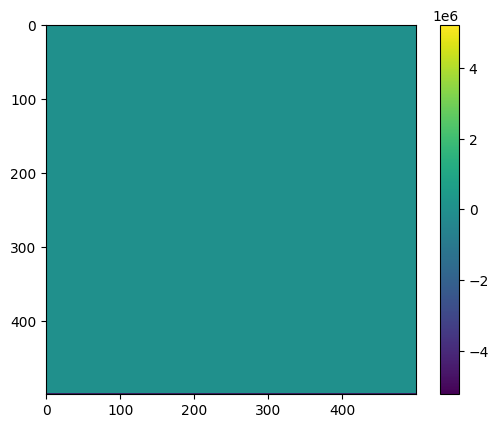

In [ ]:
#plt.imshow(phy.dtphi_o_1.sample(geo))
plt.imshow(phy.dtphi_w_1.sample(geo))
plt.colorbar()
print(phy.dtphi_w_1.sample(geo))
print(phy.dtphi_o_1.sample(geo))
print(phy.phi_o.sample(geo))

(xˢ=500, yˢ=500) -5.24e-05 ± 3.3e-01 (-5e+00...5e+00)


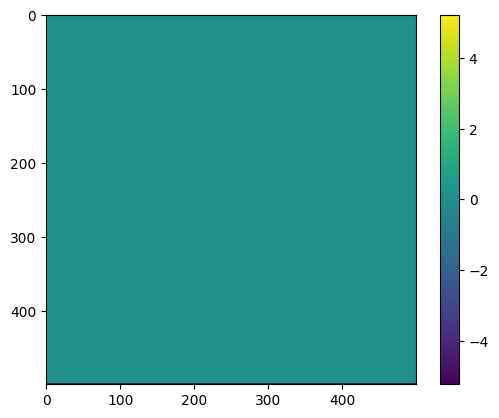

(xˢ=500, yˢ=500) const 1142.0


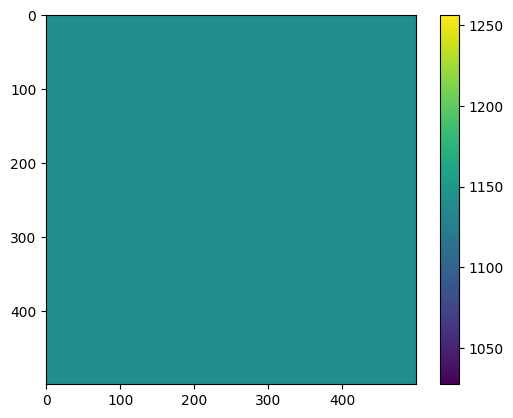

(xˢ=500, yˢ=500) const 0.8999995589256287


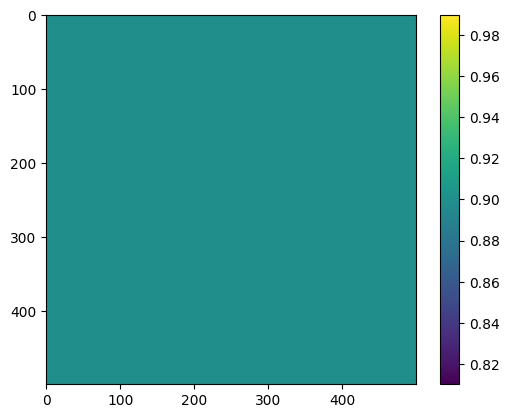

(xˢ=500, yˢ=500) 1.14e+03 ± 3.3e-01 (1e+03...1e+03)


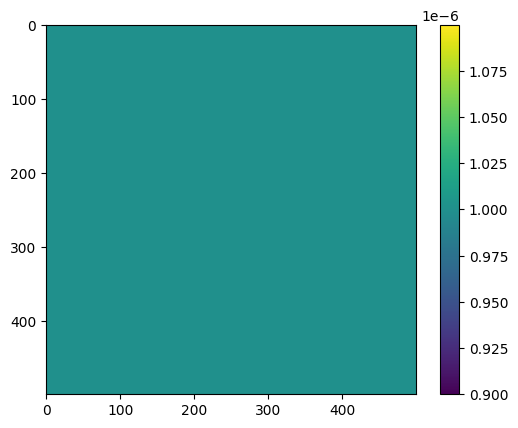

(xˢ=500, yˢ=500) const 1.0000001111620804e-06


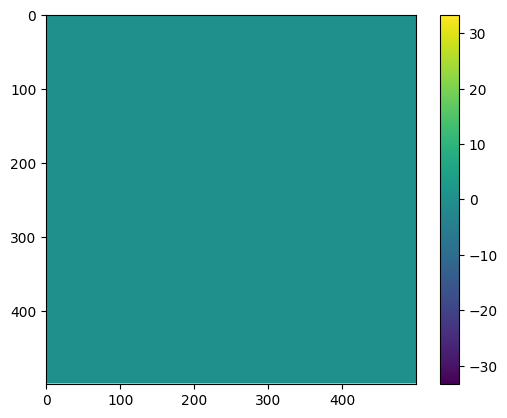

(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)


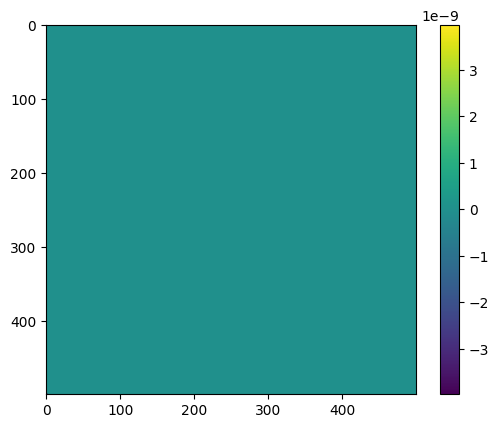

(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)
(xˢ=500, yˢ=500) const 0.8999995589256287
(xˢ=500, yˢ=500) const 0.05000000074505806
(xˢ=500, yˢ=500) const 1.0000001111620804e-06
(xˢ=500, yˢ=500) 1.14e+03 ± 3.3e-01 (1e+03...1e+03)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 0.083 ± 0.083 (0e+00...2e-01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 2.50e+04 ± 2.5e+04 (0e+00...5e+04)
(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 3.49e-21 ± 3.5e-21 (0e+00...7e-21)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 5.47e-19 ± 5.5e-19 (0e+00...1e-18)
(xˢ=500, yˢ=500) -5.23e-05 ± 3.3e-01 (-5e+00...5e+00)


In [ ]:
print(phi[0].sample(geo))
plt.imshow(phi[0].sample(geo).native("x,y"))
plt.colorbar()
plt.show()
print(phi[1].sample(geo))
plt.imshow(phi[1].sample(geo).native("x,y"))
plt.colorbar()
plt.show()
plt.imshow(S_w(phy.compute_p_c(*phi)))
plt.colorbar()
print(S_w(phy.compute_p_c(*phi)))
plt.show()
print(phy.compute_p_c(*phi))
plt.imshow(dsdpc(phy.compute_p_c(*phi)))
plt.colorbar()
plt.show()
print(dsdpc(phy.compute_p_c(*phi)))

plt.imshow(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry).native("x,y")[:,:,0])
plt.colorbar()
plt.show()
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))
plt.imshow(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry).native("x,y")[:,:,1])
plt.colorbar()
plt.show()
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))

print(S_w(phy.compute_p_c(*phi)))
print(K_w_f_t(S_w(phy.compute_p_c(*phi))))
print(dsdpc(phy.compute_p_c(*phi)))
print(phy.compute_p_c(*phi))
print(dK_w(phy.compute_p_c(*phi)))
print(K_w(phy.compute_p_c(*phi)))
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(*phi)))
print(dK_o(phy.compute_p_c(*phi)))
#print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_o.geometry))
print(phy.phi_w_momentum_eq(*phi, 1e-5).sample(phi_o.geometry))

In [ ]:
print(phy.dtphi_w_1.sample(geo))

(xˢ=240, yˢ=240) -0.005 ± 4.380 (-5e+01...5e+01)


## NS reesidual

In [ ]:
def incompresibble_fluid_loss(up,xt,mu=1,rho=1):
    l=0
    # x-velocity components
    l+=x_grad(up,xt,0,1)[...,2] # dudt
    l+=torch.sum(up[...,:1]*x_grad(up,xt,0,1)[...,:2],axis=-1) # u * grad u
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,0]) #  dpdx
    l-=(mu/rho)*torch.sum(x_grad(up,xt,0,2)[...,:2],axis=-1) # grad**2 u
    # y-velocity components
    l+=x_grad(up,xt,1,1)[...,2] # dvdt
    l+=torch.sum(up[...,1:2]*x_grad(up,xt,0,1)[...,:2],axis=-1) # v * grad v
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,1]) #  dpdy
    l-=(mu/rho)*torch.sum(x_grad(up,xt,1,2)[...,:2],axis=-1) # grad**2 v
    return l

### Debug

In [ ]:
x1 = torch.randn((3,1,3)).requires_grad_(True)  #
print(x1)
print(x1.shape)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]**0.5,
    torch.cos(x1[:,:,0]),
    ],axis=2)

print(u1.shape)

tensor([[[-1.5316, -0.0218,  1.3527]],

        [[ 2.0246,  0.5625, -0.8633]],

        [[ 0.5488, -0.9313,  0.3730]]], requires_grad=True)
torch.Size([3, 1, 3])
torch.Size([3, 1, 3])


In [ ]:
incompresibble_fluid_loss(u1,x1,1,1)-0
#x_grad(u1,x1,0,1)[...,0]
#print(x1[:,:,:1])
#print(x_grad(u1,x1,0,1)[...,:2])
#x_grad(u1,x1,0,1)[...,2]
#x_grad(u1,x1,0,2)[...,:2]

tensor([[   nan],
        [0.9955],
        [0.3642]], grad_fn=<SubBackward0>)

# reaction diffusion approach

In [2]:
from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK,two_phase_flow_RD
from phi.torch.flow import *
import matplotlib.pyplot as plt

NameError: name 'K_s' is not defined

### example

In [ ]:

@jit_compile
def reaction_diffusion(u, v, du, dv, f, k, dt):
    uvv = u * v**2
    su = du * field.laplace(u) - uvv + f * (1 - u)
    sv = dv * field.laplace(v) + uvv - (f + k) * v
    return u + dt * su, v + dt * sv


def reaction_diffusion(u, v, du, dv, f, k, dt):
    uvv = u * v**2
    su = du * field.laplace(u) - uvv + f * (1 - u)
    sv = dv * field.laplace(v) + uvv - (f + k) * v
    return u + dt * su, v + dt * sv

/tmp/ipykernel_26679/863439274.py:4: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  CenteredGrid(lambda x: math.cos(math.vec_length(x-50)/3), x=100, y=100) * .5,


TypeError: Image data of dtype object cannot be converted to float

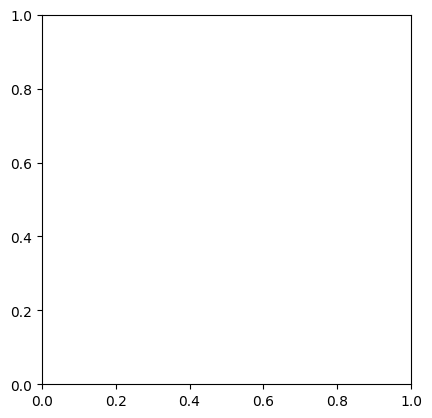

In [6]:
u0 = [
    CenteredGrid(Noise(scale=20, smoothness=1.3), x=100, y=100) * .2 + .1,
    CenteredGrid(lambda x: math.exp(-0.5 * math.sum((x - 50)**2) / 3**2), x=100, y=100),
    CenteredGrid(lambda x: math.cos(math.vec_length(x-50)/3), x=100, y=100) * .5,
]
u0 = stack(u0, batch('initialization'))
plt.imshow(u0)

In [ ]:
maze = {'du': 0.19, 'dv': 0.05, 'f': 0.06, 'k': 0.062}
u_trj, v_trj = iterate(reaction_diffusion, batch(time=100), u0, u0, dt=.5, f_kwargs=maze, substeps=20)


RuntimeError: No user interface available.

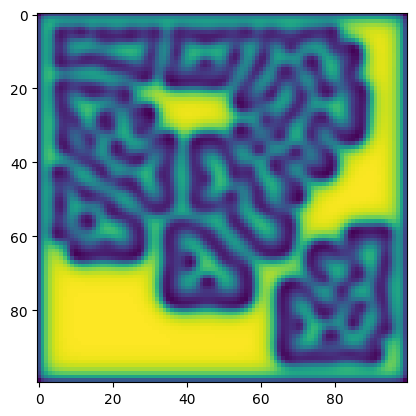

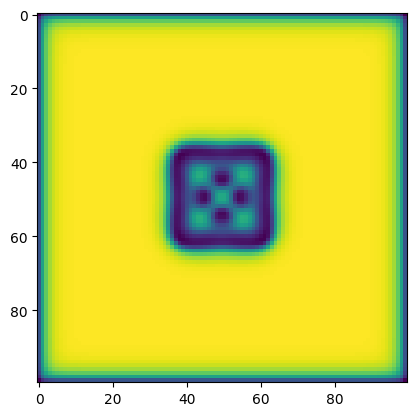

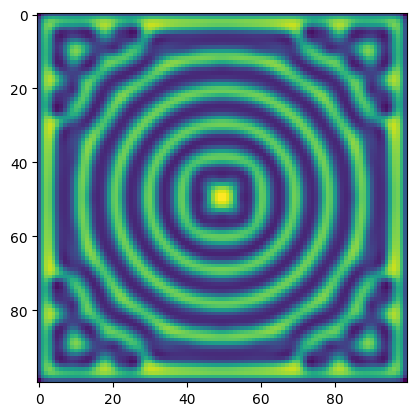

In [17]:

time=50
plt.imshow(u_trj.initialization[0].time[time].values)
plt.show()
plt.imshow(u_trj.initialization[1].time[time].values)
plt.show()
plt.imshow(u_trj.initialization[2].time[time].values)
plt.show()

### 2 phase flow with saturation dependent permeability

### Core-brooks model simulatio

In [3]:
!ls Data/
import pandas as pd
data=pd.read_csv("Data/60x60_T240_2D_2P_Darcy_flow.csv")

2D_1P_DF_eq_Dirichlet_Linear_Linear_f_zero_S20x20_T10_1000.csv
2D_NS_eq_Dirichlet_Linear_Linear_f_zero_S10x10_T10_500.csv
2D_poisson_eq_D_N_R_quad_f_Linear_Linear_64x64.csv
2D_poisson_eq_Dirichlet_BC_64x64.csv
2D_poisson_eq_Dirichlet_Const_Linear_f_Const_64x64.csv
2D_poisson_eq_Dirichlet_Const_Quad_f_Const_64x64.csv
2D_poisson_eq_Dirichlet_Const_f_Const_64x64.csv
2D_poisson_eq_Dirichlet_Exp_Exp_f_Const_64x64.csv
2D_poisson_eq_Dirichlet_Exp_Exp_f_Linear_Linear_64x64.csv
2D_poisson_eq_Dirichlet_Linear_Linear_f_Const_64x64.csv
2D_poisson_eq_Dirichlet_Quad_Quad_f_Const_64x64.csv
32x32_2D_poisson_eq_Dirichlet_BC.csv
32x32_2D_poisson_eq_Dirichlet_BC2.csv
3D_NS_eq_Dirichlet_Linear_Linear_f_zero_S10x10_T10_500.csv
3D_poisson_eq_Dirichlet_BC_64x64x64.csv
3D_poisson_eq_Dirichlet_Const_Linear_f_Const_64x64.csv
60x60_T240_2D_2P_Darcy_flow.csv
64x64_2D_poisson_eq_Dirichlet_BC.csv
64x64_2D_poisson_eq_Dirichlet_BC2.csv
64x64_2D_poisson_eq_Dirichlet_BC3.csv
64x64_2D_poisson_eq_Dirichlet_BC4.csv
64x64_

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_683343/1266182344.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K_s[int((np.unique(x/50)-1)/2),int((np.unique(y/50)-1)/2)]=k


array([[1000., 1000., 1000., ...,  100.,  100.,  100.],
       [1000., 1000., 1000., ...,  100.,  100.,  100.],
       [1000., 1000., 1000., ...,  100.,  100.,  100.],
       ...,
       [ 100.,  100.,  100., ...,  100.,  100.,  100.],
       [ 100.,  100.,  100., ...,  100.,  100.,  100.],
       [ 100.,  100.,  100., ...,  100.,  100.,  100.]])

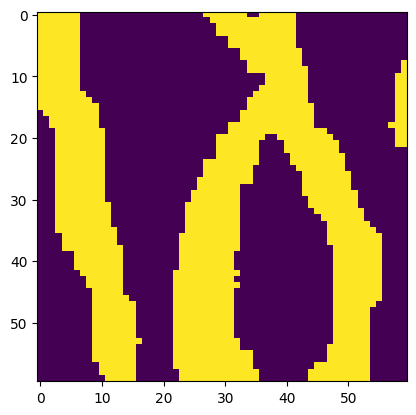

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sympy
from copy import deepcopy
from scipy import ndimage

data["Ki"]

K_s=np.ones((60,60))
for x,y,k in zip(data.x.values[:],data.y.values[:],data["Ki"].values[:]):
    #K_s[int(x/50)-1,int(y/50)-1]
    K_s[int((np.unique(x/50)-1)/2),int((np.unique(y/50)-1)/2)]=k
#K_s=ndimage.zoom(K_s,(0.6,0.6)) * 9.869233e-13
plt.imshow(K_s)
K_s

In [58]:
import sys
import os
sys.path.append(os.path.join(ROOT,"sympytorch","sympytorch"))
sys.path.append(os.path.join(ROOT,"sympytorch"))
print(os.path.join(ROOT,"sympytorch","sympytorch"))

/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning/sympytorch/sympytorch


In [62]:
#from sympytorch import SymPyModule
from sympy_module import SymPyModule as SymPyModule
from sympy_module import SymPyPhiFlowModule
from hide_floats_m import hide_floats

In [7]:
import sympytorch
Sw_args={
    "SWR":0.01,
    "SOR":0.20
}
Pc_args=Sw_args.copy()

Pc_args.update({
    "lam":0.5,
    "Pi":1e3
    })

SWR=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
K_rw0=sympy.symbols("k_{rw0}")
K_ro0=sympy.symbols("k_{ro0}")

Pc_=sympy.symbols("P_c")

Sc=(Sw-SWR)/(1-SWR-SOR)
Pc=Pi*Sc**(-1/lam)

Sw_Pc=(1-SWR-SOR)*((Pc_/Pi)**(-1*lam))+SWR
dScdPc=sympy.diff(Sw_Pc,Pc_)

K_rw=K_rw0*Sc**((2+3*lam)/(lam))
K_ro=K_ro0*((1-Sc)**2)*(1-Sc**((2+lam)/(lam)))
Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWR,lam,Pi),Pc)(sw,*tuple(Pc_args.values()))

Pc_f_torch=SymPyModule(expressions=[Pc.subs(list(map(lambda k:(eval(k),Pc_args[k]) ,Pc_args)))])

#Pc_f_torch=sympytorch.SymPyModule(expressions=[Pc])
#Pc_f(0.1)

In [64]:
from phiml.math import sum as phi_sum
from phiml import math as pmath
import numpy as np
from scipy import ndimage
import sympy
from sympy_module import SymPyPhiFlowModule,_reduce
import operator
from functools import reduce
#from Differentiable_simulation import SWC,SOR,Sw,lam,Pi,K_rw0,K_ro0,Pc_,Sw_Pc

K_s=K_s * 9.869233e-13

class two_phase_flow_RD(object):
  def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt,por,mu_w,mu_o,K_s,kr_w,kr_o,Pc_args):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dtphi_o_1=dtphi_o_1
    self.dtphi_w_1=dtphi_w_1
    self.dt=dt
    self.p=None
    self.K_l=K_s
    self.por=por
    self.mu_w=mu_w
    self.mu_o=mu_o

    SWR=sympy.symbols("S_{wc}")
    SOR=sympy.symbols("S_{or}")
    Sw=sympy.symbols("S_w")
    lam=sympy.symbols("\lambda")
    Pi=sympy.symbols("P_i")
    K_rw0=sympy.symbols("k_{rw0}")
    K_ro0=sympy.symbols("k_{ro0}")
    
    Pc_=sympy.symbols("P_c")
    
    Sc=(Sw-SWR)/(1-SWR-SOR)
    Pc=Pi*Sc**(-1/lam)
    
    Sw_Pc=(1-SWR-SOR)*((Pc_/Pi)**(-1*lam))+SWR
    dScdPc=sympy.diff(Sw_Pc,Pc_)
    
    
    #K_rw=K_rw0*Sc**((2+3*lam)/(lam))
    K_rw=K_rw0*Sc**((0+3*lam)/(lam))
    K_ro=K_ro0*((1-Sc)**2)*(1-Sc**((2+lam)/(lam)))

    #self.Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWR,lam,Pi),Pc)(sw,*tuple(Pc_args.values()))
    #self.Sw_Pc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWR,lam,Pi),Sw_Pc)(sw,*tuple(Pc_args.values()))
    #
    #self.K_rw_f=lambda sw: sympy.lambdify((Sw,SOR,SWR,lam,Pi,K_rw0),K_rw)(sw,*tuple(Pc_args.values()),kr_w)
    #self.K_ro_f=lambda sw: sympy.lambdify((Sw,SOR,SWR,lam,Pi,K_ro0),K_ro)(sw,*tuple(Pc_args.values()),kr_o)
    #self.dK_rw_f=lambda sw: sympy.lambdify((Sw,SOR,SWR,lam,Pi,K_rw0),sympy.diff(K_rw,Sw))(sw,*tuple(Pc_args.values()),0.3)
    #self.dK_ro_f=lambda sw: sympy.lambdify((Sw,SOR,SWR,lam,Pi,K_ro0),sympy.diff(K_ro,Sw))(sw,*tuple(Pc_args.values()),0.5)
#
    #
    #self.dScdPc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWR,lam,Pi),dScdPc)(sw,*tuple(Pc_args.values()))

    self.Pc_f_pyt=SymPyPhiFlowModule(expressions=[hide_floats(Pc.subs(list(map(lambda k:(eval(k),Pc_args[k]) ,Pc_args))))])
    self.Pc_f=lambda x: self.Pc_f_pyt(S_w=x)[0]
    self.Sw_Pc_f_pyt=SymPyPhiFlowModule(expressions=[hide_floats(Sw_Pc.subs(list(map(lambda k:(eval(k),Pc_args[k]) ,Pc_args))))],
      update_funcs={sympy.Pow: (lambda x,y: x**y),
                    sympy.Mul: _reduce(operator.mul),
                    #sympy.Add: lambda x,y:x+y
                    #sympy.Add: lambda iter:reduce(lambda x,y:x+y,list(iter))
                    sympy.Add: _reduce(lambda x,y:x+y)
                    }
      )
    self.Sw_Pc_f=lambda x: self.Sw_Pc_f_pyt(P_c=x)[0]

    self.K_rw_f_pyt=SymPyPhiFlowModule(expressions=[hide_floats(K_rw.subs(list(map(lambda k:(eval(k),Pc_args[k]) ,Pc_args)) + [(K_rw0,0.3)] ))])
    self.K_rw_f=lambda x: self.K_rw_f_pyt(S_w=x)[0]
    self.dK_rw_f_pyt=SymPyPhiFlowModule(expressions=[hide_floats(sympy.diff(K_rw,Sw).subs(list(map(lambda k:(eval(k),Pc_args[k]) ,Pc_args)) + [(K_rw0,0.3)] ))])
    self.dK_rw_f=lambda x: self.dK_rw_f_pyt(S_w=x)[0]
    #self.K_ro_f_pyt=SymPyPhiFlowModule(expressions=[hide_floats(K_ro.subs(list(map(lambda k:(eval(k),Pc_args[k]) ,Pc_args)) + [(K_ro0,0.5)] ))])
    self.K_ro_f_pyt=SymPyPhiFlowModule(expressions=[hide_floats(sympy.expand(K_ro.subs(list(map(lambda k:(eval(k),Pc_args[k]) ,Pc_args)) + [(K_ro0,0.5)] )))])
    self.K_ro_f=lambda x: self.K_ro_f_pyt(S_w=x)[0]
    self.dK_ro_f_pyt=SymPyPhiFlowModule(expressions=[hide_floats(sympy.diff(K_ro,Sw).subs(list(map(lambda k:(eval(k),Pc_args[k]) ,Pc_args)) + [(K_ro0,0.5)] ))])
    self.dK_ro_f=lambda x: self.dK_ro_f_pyt(S_w=x)[0]

    self.dScdPc_f_pyt=SymPyPhiFlowModule(expressions=[hide_floats(dScdPc.subs(list(map(lambda k:(eval(k),Pc_args[k]) ,Pc_args))))])
    self.dScdPc_f=lambda x: self.dScdPc_f_pyt(P_c=x)[0]

    self.K_w=lambda K_l,p_c:stack(
          [stack([K_l*self.K_rw_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_w*self.dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
          stack([math.zeros_like(p_c),K_l*self.K_rw_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_w*self.dScdPc_f(p_c))],batch("k") )],batch("KK"))

    self.K_o=lambda K_l,p_c:stack(
        [stack([K_l*self.K_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o*self.dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
        stack([math.zeros_like(p_c),K_l*self.K_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o*self.dScdPc_f(p_c))],batch("k") )],batch("KK"))

    self.dK_w=lambda K_l,p_c:stack(
        [stack([K_l*self.dK_rw_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_w),math.zeros_like(p_c)],batch("dk") ),
        stack([math.zeros_like(p_c),K_l*self.dK_rw_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_w)],batch("dk") )],batch("dKK"))

    self.dK_o=lambda K_l,p_c:stack(
        [stack([K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o),math.zeros_like(p_c)],batch("dk") ),
        stack([math.zeros_like(p_c),K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o)],batch("dk") )],batch("dKK"))
    
    self.grad_phi_dK = lambda phi_a,dK_a:(math.dot(field.spatial_gradient(phi_a,phi_a.boundary).sample(phi_a.geometry),"vector",dK_a,"dKK"))


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_o.sample(phi_o.geometry) -\
    phi_w.sample(phi_w.geometry)
    p_c=pmath.clip(p_c,lower_limit=self.Pc_f(1-Sw_args["SOC"]),upper_limit=self.Pc_f(Sw_args["SWR"]))
    return p_c

  def compute_convective_velocity(self,phi_a,phi_b,dK_a,dK_b):
    p_c=self.compute_p_c(phi_a,phi_b)
    convective_velocity = self.grad_phi_dK(phi_a,dK_a(self.K_l,p_c))\
                         - self.grad_phi_dK(phi_b,dK_b(self.K_l,p_c))

    V=unstack(convective_velocity,"dk")
    convective_velocity=Field(self.phi_o.geometry,values=vec(x=V[0],y=V[1]))
    return convective_velocity
  
  def phi_w_pde(self,phi_w,phi_o,dtphi_o):
    p_c=self.compute_p_c(phi_w,phi_o)
    
    w_advection_term = phi_sum(
      self.compute_convective_velocity(phi_w,phi_o,self.dK_w,self.dK_w)*phi_w.gradient(),
      "vector").sample(phi_w.geometry)
    
    x,y=unstack(phi_sum(self.K_w(self.K_l,p_c),"KK"),"k")
    spatial_diffusion=Field(phi_w.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_w.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))

    pressure_chage_term = (dtphi_o.values)

    return phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_advection_term) - phi_w.with_values(w_diffusion_term)
  
  def phi_o_pde(self,phi_o,phi_w,dtphi_w):
    p_c=self.compute_p_c(phi_w,phi_o)
    
    w_advection_term = phi_sum(
      self.compute_convective_velocity(phi_w,phi_o,self.dK_o,self.dK_o)*phi_o.gradient(),
      "vector").sample(phi_o.geometry)
    
    x,y=unstack(phi_sum(self.K_o(self.K_l,p_c),"KK"),"k")
    spatial_diffusion=Field(phi_o.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_o.with_values(phi_sum(phi_o.gradient(2)*spatial_diffusion,"vector"))

    pressure_chage_term = (dtphi_w.values)

    return phi_o.with_values(pressure_chage_term) + phi_o.with_values(w_advection_term) - phi_o.with_values(w_diffusion_term)
  
  def RK4(self,phi_w,phi_o,dt):

    K_o1=self.phi_o_pde(phi_o,phi_w,self.dtphi_w_1)
    K_w1=self.phi_w_pde(phi_w,phi_o,self.dtphi_o_1)

    K_o2=self.phi_o_pde(phi_o+0.5*K_o1.values*dt,phi_w+0.5*K_w1.values*dt,K_w1)
    K_w2=self.phi_w_pde(phi_w+0.5*K_w1.values*dt,phi_o+0.5*K_o1.values*dt,K_o1)

    K_o3=self.phi_o_pde(phi_o+0.5*K_o2.values*dt,phi_w+0.5*K_w2.values*dt,K_w2)
    K_w3=self.phi_w_pde(phi_w+0.5*K_w2.values*dt,phi_o+0.5*K_o2.values*dt,K_o2)

    K_o4=self.phi_o_pde(phi_o+K_o3.values*dt,phi_w+K_w3.values*dt,K_w3)
    K_w4=self.phi_w_pde(phi_w+K_w3.values*dt,phi_o+K_o3.values*dt,K_o3)

    self.dtphi_o_1 = (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4)
    self.dtphi_w_1 = (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4)

    phi_o = phi_o.with_values(pmath.finite_fill(pmath.clip(phi_o.values + dt * (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4).values,lower_limit=0.0,upper_limit=1e6)))
    phi_w = phi_w.with_values(pmath.finite_fill(pmath.clip(phi_w.values + dt * (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4).values,lower_limit=0.0,upper_limit=phi_o.values)))
    return phi_w,phi_o
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_o = phi_o + dt * self.phi_o_pde(phi_o,phi_w,self.dtphi_w_1)
    new_phi_w = phi_w + dt * self.phi_w_pde(phi_w,phi_o,self.dtphi_o_1)
    self.dtphi_w_1,self.dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o
  

class two_phase_flow_RD_decoupled_DT(two_phase_flow_RD):
  def RK4(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt):

    K_o1=self.phi_o_pde(phi_o,phi_w,dtphi_w_1)
    K_w1=self.phi_w_pde(phi_w,phi_o,dtphi_o_1)

    K_o2=self.phi_o_pde(phi_o+0.5*K_o1.values*dt,phi_w+0.5*K_w1.values*dt,K_w1)
    K_w2=self.phi_w_pde(phi_w+0.5*K_w1.values*dt,phi_o+0.5*K_o1.values*dt,K_o1)

    K_o3=self.phi_o_pde(phi_o+0.5*K_o2.values*dt,phi_w+0.5*K_w2.values*dt,K_w2)
    K_w3=self.phi_w_pde(phi_w+0.5*K_w2.values*dt,phi_o+0.5*K_o2.values*dt,K_o2)

    K_o4=self.phi_o_pde(phi_o+K_o3.values*dt,phi_w+K_w3.values*dt,K_w3)
    K_w4=self.phi_w_pde(phi_w+K_w3.values*dt,phi_o+K_o3.values*dt,K_o3)

    dtphi_o_1 = (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4)
    dtphi_w_1 = (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4)

    phi_o = phi_o.with_values(pmath.finite_fill(pmath.clip(phi_o.values + dt * (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4).values,lower_limit=0.0,upper_limit=1e6)))
    phi_w = phi_w.with_values(pmath.finite_fill(pmath.clip(phi_w.values + dt * (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4).values,lower_limit=0.0,upper_limit=phi_o.values)))
    return phi_w,phi_o,dtphi_w_1,dtphi_o_1
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o,dtphi_w_1,dtphi_o_1, dt):
    new_phi_o = phi_o + dt * self.phi_o_pde(phi_o,phi_w,dtphi_w_1)
    new_phi_w = phi_w + dt * self.phi_w_pde(phi_w,phi_o,dtphi_o_1)
    dtphi_w_1,dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o,dtphi_w_1,dtphi_o_1

In [65]:
#from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *

Sw_args={
    "SWR":0.01,
    "SOC":0.20
}
Pc_args=Sw_args.copy()
Pc_args.update({
    "lam":0.5,
    "Pi":1e3
    })


geo=UniformGrid(x=60, y=60,bounds=Box(x=6e3, y=6e3))
phi_w = Field( geo,values=tensor(0.0),
      boundary= {
          'x-':5e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phi_o=Field( geo,values=tensor(p_o),
      boundary= {
          'x-': p_o + 5e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })




phy=two_phase_flow_RD(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
    por=0.1,
    mu_w=0.32,
    mu_o=1.295,
    K_s=K_s,
    kr_w=0.4,
    kr_o=0.3,
    Pc_args=Pc_args
)



In [21]:
phi_t=[]
phi=(phi_w,phi_o)
phi_t.append(phi)
for i in range(240):
    print(i)
    
    phi=phy.RK4(*phi,1e3)
    #phi=phy.implicit_time_step(*phi,1e5)
    phi_t.append(phi)
    
    if np.isnan(np.sum(phy.compute_p_c(*phi).numpy("x,y"))):
        print("nan")
        print(i)
        break

0


/tmp/ipykernel_683343/3931936816.py:99: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  [stack([K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o),math.zeros_like(p_c)],batch("dk") ),
/tmp/ipykernel_683343/3931936816.py:100: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  stack([math.zeros_like(p_c),K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o)],batch("dk") )],batch("dKK"))
/tmp/ipykernel_683343/3931936816.py:91: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


In [ ]:
#for f in np.array(phi_t):
#for t,f in enumerate(phi_t[::10]):
for t,f in enumerate(phi_t[::-10]):
    fig,axs=plt.subplots(1,5,figsize=(15,5))
    #axs[0].imshow(Sw_Pc_f(phy.compute_p_c(*f)))
    pcm = axs[0].pcolormesh(phy.Sw_Pc_f(phy.compute_p_c(*f)).numpy("y,x"))
    axs[0].title.set_text("Sw")
    fig.colorbar(pcm,ax=axs[0])
    pcm = axs[1].pcolormesh(phy.compute_p_c(*f).numpy("y,x"))
    axs[1].title.set_text("P_c")
    fig.colorbar(pcm,ax=axs[1])

    #pcm = axs[2].pcolormesh(1/dScdPc_f(phy.compute_p_c(*f)).numpy("y,x"))
    #axs[2].title.set_text("1/dS")
    #fig.colorbar(pcm,ax=axs[2])

    pcm = axs[2].pcolormesh(phi_sum(
      phy.compute_convective_velocity(*f,phy.dK_w,phy.dK_o)*f[1].gradient(),
      "vector").numpy("y,x"))
    axs[2].title.set_text("1/dS")
    fig.colorbar(pcm,ax=axs[2])

    pcm = axs[3].pcolormesh(f[0].numpy("y,x"))
    axs[3].title.set_text("phi_w")
    fig.colorbar(pcm,ax=axs[3])

    pcm = axs[4].pcolormesh(f[1].numpy("y,x"))
    axs[4].title.set_text("phi_o")
    fig.colorbar(pcm,ax=axs[4])


    print(t)
    plt.show()


### Table based simulation

0.75
0.74


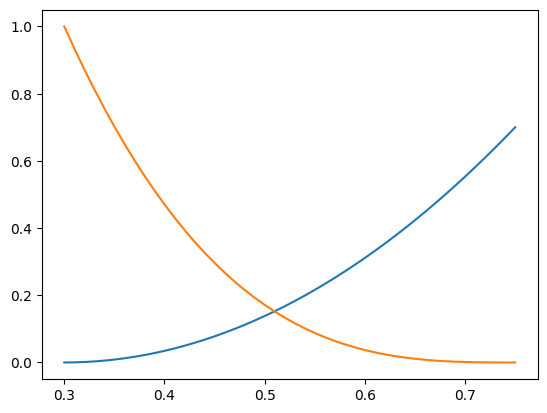

In [92]:
#**$      p  kpa      Rs        Bo        Bg      viso      visg
#        1.000         1         1         1     1.295       0.1
#      173.352        10         1       0.1     1.294       0.1
#      400.000        20         1      0.01     1.293       0.1

#Sw   krw      krow
SKr=np.array([[0.300, 0., 1.000000],
[0.310, 0.000346, 0.934804],
[0.320, 0.001383, 0.872505],
[0.330, 0.003111, 0.813037],
[0.340, 0.005531, 0.756335],
[0.350, 0.008642, 0.702332],
[0.360, 0.012444, 0.650963],
[0.370, 0.016938, 0.602162],
[0.380, 0.022123, 0.555863],
[0.390, 0.028000, 0.512000],
[0.400, 0.034568, 0.470508],
[0.410, 0.041827, 0.431320],
[0.420, 0.049778, 0.394370],
[0.430, 0.058420, 0.359594],
[0.440, 0.067753, 0.326925],
[0.450, 0.077778, 0.296296],
[0.460, 0.088494, 0.267643],
[0.470, 0.099901, 0.240900],
[0.480, 0.112000, 0.216000],
[0.490, 0.124790, 0.192878],
[0.500, 0.138272, 0.171468],
[0.510, 0.152444, 0.151704],
[0.520, 0.167309, 0.133520],
[0.530, 0.182864, 0.116850],
[0.540, 0.199111, 0.101630],
[0.550, 0.216049, 0.087791],
[0.560, 0.233679, 0.075270],
[0.570, 0.252000, 0.064000],
[0.580, 0.271012, 0.053915],
[0.590, 0.290716, 0.044949],
[0.600, 0.311111, 0.037037],
[0.610, 0.332198, 0.030112],
[0.620, 0.353975, 0.024110],
[0.630, 0.376444, 0.018963],
[0.640, 0.399605, 0.014606],
[0.650, 0.423457, 0.010974],
[0.660, 0.448000, 0.008000],
[0.670, 0.473235, 0.005619],
[0.680, 0.499160, 0.003764],
[0.690, 0.525778, 0.002370],
[0.700, 0.553086, 0.001372],
[0.710, 0.581086, 0.000702],
[0.720, 0.609778, 0.000296],
[0.730, 0.639160, 0.000088],
[0.740, 0.669235, 0.000011],
[0.750, 0.700000, 0.000000]])

plt.plot(SKr[:,0],SKr[:,1])
plt.plot(SKr[:,0],SKr[:,2])

def linear_interpolation(Tf,x):
    i1=np.argmin(np.abs(Tf[:,0]-x))
    x1=Tf[i1,0]
    y1=Tf[i1,1]
    Tf[i1,0]=1e6
    i2=np.argmin(np.abs(Tf[:,0]-x))
    x2=Tf[i2,0]
    y2=Tf[i2,1]
    dy=(y1-y2)
    dx=(x1-x2)
    print(x1)
    print(x2)
    y=y1+(dy/dx)*(x-x1)
    return np.clip(y,0.0,1.0),(dy/dx)

linear_interpolation(SKr[:,[0,2]],1.0)
#SKr[:,[0,2]]


import torch
import math


class Kr_LinearInterpolation(torch.autograd.Function):
    """
    custom implementation of linear interpolation in pytorch
    """
    @staticmethod
    def forward(ctx, input,Tf):
        ctx.save_for_backward(input,Tf)
        i1=np.argmin(np.abs(Tf[:,0]-input))
        x1=Tf[i1,0]
        y1=Tf[i1,1]
        Tf[i1,0]=1e6
        i2=np.argmin(np.abs(Tf[:,0]-input))
        x2=Tf[i2,0]
        y2=Tf[i2,1]
        dy=(y1-y2)
        dx=(x1-x2)
        y=y1+(dy/dx)*(input-x1)
        print(y)
        return np.clip(y,0.0,1.0)
        #return 0.5 * (5 * input ** 3 - 3 * input)
    

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input,Tf = ctx.saved_tensors
        i1=np.argmin(np.abs(Tf[:,0]-input))
        x1=Tf[i1,0]
        y1=Tf[i1,1]
        Tf[i1,0]=1e6
        i2=np.argmin(np.abs(Tf[:,0]-input))
        x2=Tf[i2,0]
        y2=Tf[i2,1]
        dy=(y1-y2)
        dx=(x1-x2)
        return grad_output * (dy/dx)
    
class dKr_LinearInterpolation(torch.autograd.Function):
    """
    custom implementation of linear interpolation in pytorch
    """
    @staticmethod
    def forward(ctx, input,Tf):
        ctx.save_for_backward(input,Tf)
        i1=np.argmin(np.abs(Tf[:,0]-input))
        x1=Tf[i1,0]
        y1=Tf[i1,1]
        Tf[i1,0]=1e6
        i2=np.argmin(np.abs(Tf[:,0]-input))
        x2=Tf[i2,0]
        y2=Tf[i2,1]
        dy=(y1-y2)
        dx=(x1-x2)
        y=y1+(dy/dx)*(input-x1)
        print(y)
        return dy/dx
        #return 0.5 * (5 * input ** 3 - 3 * input)
    

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input,Tf = ctx.saved_tensors
        i1=np.argmin(np.abs(Tf[:,0]-input))
        x1=Tf[i1,0]
        y1=Tf[i1,1]
        Tf[i1,0]=1e6
        i2=np.argmin(np.abs(Tf[:,0]-input))
        x2=Tf[i2,0]
        y2=Tf[i2,1]
        dy=(y1-y2)
        dx=(x1-x2)
        return grad_output # Obs: this assumes linear interpolation, and 2 order derivatives are not implemented yet

In [101]:
# a exp(b x) =y
# log a + b x = log y
np.sum(SKr[:,[0,1]],axis=0)
#SKr.shape

array([24.15    , 10.852591])

In [102]:
from copy import copy




class two_phase_flow_RD_TBK(two_phase_flow_RD_decoupled_DT):
    def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt,por,mu_w,mu_o,Pc_args,K_s,krwo):
        super().__init__(phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt,por,mu_w,mu_o,K_s=K_s,Pc_args=Pc_args,kr_w=0.3,kr_o=0.3)
        self.krwo=krwo

        self.K_w=lambda K_l,p_c:stack(
              [stack([K_l*self.K_rw_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_w*self.dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
              stack([math.zeros_like(p_c),K_l*self.K_rw_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_w*self.dScdPc_f(p_c))],batch("k") )],batch("KK"))

        self.K_o=lambda K_l,p_c:stack(
            [stack([K_l*self.K_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o*self.dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
            stack([math.zeros_like(p_c),K_l*self.K_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o*self.dScdPc_f(p_c))],batch("k") )],batch("KK"))

        self.dK_w=lambda K_l,p_c:stack(
            [stack([K_l*self.dK_rw_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_w),math.zeros_like(p_c)],batch("dk") ),
            stack([math.zeros_like(p_c),K_l*self.dK_rw_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_w)],batch("dk") )],batch("dKK"))

        self.dK_o=lambda K_l,p_c:stack(
            [stack([K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o),math.zeros_like(p_c)],batch("dk") ),
            stack([math.zeros_like(p_c),K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o)],batch("dk") )],batch("dKK"))

        self.grad_phi_dK = lambda phi_a,dK_a:(math.dot(field.spatial_gradient(phi_a,phi_a.boundary).sample(phi_a.geometry),"vector",dK_a,"dKK"))

        # Autograd definitions
        #self.K_rw_f = lambda x: Kr_LinearInterpolation.apply(x,copy(self.krwo[:,[0,1]]))
        #self.dK_rw_f = lambda x: dKr_LinearInterpolation.apply(x,copy(self.krwo[:,[0,2]]))
        #self.K_ro_f = lambda x: Kr_LinearInterpolation.apply(x,copy(self.krwo[:,[0,1]]))
        #self.dK_ro_f = lambda x: dKr_LinearInterpolation.apply(x,copy(self.krwo[:,[0,2]]))

        # Exponential interpolation definition
        self.get_exp()
        self.K_rw_f = lambda x: self.A_rw*pmath.exp(self.k_rw*x)
        self.dK_rw_f = lambda x: self.k_rw*self.A_rw*pmath.exp(self.k_rw*x)
        self.K_ro_f = lambda x: self.A_ro*pmath.exp(self.k_ro*x)
        self.dK_ro_f = lambda x: self.k_ro*self.A_ro*pmath.exp(self.k_ro*x)


    def get_exp(self):
        n=self.krwo.shape[0]
        self.k_rw=(np.sum(np.prod(self.krwo[:,[0,1]],axis=1))-(1/n)*np.prod(np.sum(self.krwo[:,[0,1]],axis=0)))\
            /(np.sum(self.krwo[:,0]**2)-(1/n)*np.sum(self.krwo[:,0])**2)
        a=(1/n)*(np.sum(self.krwo[:,1],axis=0)-np.sum(self.krwo[:,0],axis=0))
        self.A_rw=np.exp(a)
        self.k_ro=(np.sum(np.prod(self.krwo[:,[0,2]],axis=1))-(1/n)*np.prod(np.sum(self.krwo[:,[0,2]],axis=0)))\
            /(np.sum(self.krwo[:,0]**2)-(1/n)*np.sum(self.krwo[:,0])**2)
        a=(1/n)*(np.sum(self.krwo[:,2],axis=0)-np.sum(self.krwo[:,0],axis=0))
        self.A_ro=np.exp(a)

In [114]:
#from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
#from Differentiable_simulation import two_phase_flow_RD_TBK
from phi.torch.flow import *

Sw_args={
    "SWR":0.01,
    "SOC":0.20
}
Pc_args=Sw_args.copy()
Pc_args.update({
    "lam":0.5,
    "Pi":1e3
    })
SWC=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
Sc=(Sw-SWC)/(1-SWC-SOR)
Pc=Pi*Sc**(-1/lam)
Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,*tuple(Pc_args.values()))
p_o=Pc_f(0.05)

geo=UniformGrid(x=240, y=240,bounds=Box(x=6e3, y=6e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phi_o=Field( geo,values=tensor(p_o),
      boundary= {
          'x-': p_o + 2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })




phy=two_phase_flow_RD_TBK(
#phy=two_phase_flow_RD_decoupled_DT(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=1e3,
    por=0.1,
    mu_w=0.32,
    mu_o=1.295,
    Pc_args=Pc_args,
    K_s=ndimage.zoom(K_s,(4.,4.)) * 9.869233e-13,
    krwo=SKr
)

#### SOL

In [27]:
import torch
from einops import rearrange
import matplotlib.pyplot as plt

class simple_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv2d(2, 32, (9,9), padding=4)
    self.conv2=torch.nn.Conv2d(32, 64, (9,9), padding=4)
    self.conv3=torch.nn.Conv2d(64, 2, (9,9), padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x):
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))*0.01
    #x=torch.clamp(x, min=-0.5, max=0.5)
    return x
  
class simple_dual_space_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_dual_space_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv2d(2, 32, (9,9), padding=4)
    self.conv2=torch.nn.Conv2d(32, 64, (9,9), padding=4)
    self.conv3=torch.nn.Conv2d(64, 2, (9,9), padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x1,x2):
    x=torch.concatenate((x1,x2),axis=1)
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))*0.01

    #x=torch.clamp(x, min=-0.5, max=0.5)
    return x[:,0],x[:,1]

In [28]:
from random import choice,sample
from phi.torch.flow import *

def Space2Tensor(Space,geometry,space_signature='x,y,vector',tensor_signature="b x y c->b c x y"):
  return rearrange(Space.sample(geometry).native(space_signature).unsqueeze(0),tensor_signature)


def Tensor2Space(Tensor,geometry,tensor_signature='c x y->x y c',space_signature="x:s,y:s,vector:c"):
  #return math.wrap(rearrange(Tensor[0],'c x y->x y c'),"x:s,y:s,vector:c")
  return Field(geometry=geometry,values=math.wrap(rearrange(Tensor,tensor_signature),space_signature))

class SOL_trainer(object):
    def __init__(self,ph_model,coarse_model,model,optimizer,simulation_steps,time_step,gt_factor,batch_size,train_horizon):

      self.Space2Tensor= lambda Space,geometry:Space2Tensor(Space,geometry,space_signature='x,y,vector',tensor_signature="b x y c ->b c x y")
      self.Tensor2Space= lambda Tensor,geometry:Tensor2Space(Tensor,geometry,space_signature="x:s,y:s",tensor_signature="x y -> x y")
      
      self.co_dt=time_step
      self.gt_dt=time_step*gt_factor
      self.gt_factor=gt_factor

      self.v_co=coarse_model  # (Field (x y) Field (x y))

      self.v_gt=copy(coarse_model)

      self.init_states_gt=[self.v_gt]
      self.ph_model=ph_model

      for i in range(train_horizon):
        self.init_states_gt.append(self.ph_model.RK4(*self.init_states_gt[-1],1e5)) # list [ horizon (Field[x y] Field[x y]) ]

      self.n_steps=simulation_steps
      self.st_model=model
      self.batch_size=batch_size

      self.loss=(lambda y_,y: torch.sum((y-y_)**2)/self.n_steps)

      self.optimizer=optimizer

      self.alpha=1

    def forward_prediction_correction(self):
      #print(f"prediction correction simulation")

      states_pred=[self.v_co]
      #print(self.v_co[0].shape)
      correction=self.st_model(
          self.Space2Tensor(self.v_co[0],self.v_co[0].geometry),
          self.Space2Tensor(self.v_co[1],self.v_co[1].geometry)
          )
      #print(correction[0].shape)
      states_corr=[(
        self.Tensor2Space(correction[0][0],self.v_co[0].geometry),
        self.Tensor2Space(correction[1][0],self.v_co[0].geometry)
        )]

      states_pred=[
        (self.v_co[0]+states_corr[-1][0],
         self.v_co[1]+states_corr[-1][1],
         )
        ]

      # For steps in correction run (4 in example) (incidencia nos iniciais)
      for i in range(self.n_steps):
        print("internal step")
        print(i)
        #print(states_pred[-1])

        # Step last in states_pred
        states_pred.append(self.ph_model.RK4(*states_pred[-1],self.co_dt))
        # Correct with model of last states_pred
        #print("forward prediction")
        #print(states_pred[-1][0].shape)
        correction=self.st_model(
          self.Space2Tensor(states_pred[-1][0],self.v_co[0].geometry),
          self.Space2Tensor(states_pred[-1][1],self.v_co[1].geometry)
          )
        states_corr.append((
          self.Tensor2Space(correction[0][0],self.v_co[0].geometry),
          self.Tensor2Space(correction[1][0],self.v_co[1].geometry)
          ))
        # Sum correction to last in states pred
        states_pred[-1]=(states_pred[-1][0]+states_corr[-1][0],
                         states_pred[-1][1]+states_corr[-1][1]
                         )

      #states_pred=list(map(lambda corr:self.Space2Tensor(corr,self.v_co[0].geometry),states_pred))
      states_pred=list(map(lambda corr:
                           (self.Space2Tensor(corr[0],self.v_co[0].geometry),
                                        self.Space2Tensor(corr[1],self.v_co[1].geometry))
                                        ,states_pred)) # b c x y

      return states_pred,states_corr

    def roll_to_batch(self,roll):
      """
      conver roll to batch
      roll list of tuples of tensors [H (T_space1 T_space1)]
      """
      return torch.concat(list(map( lambda ss:torch.concat(ss,axis=1),roll )),axis=1)
      
    def forward_fine_grained(self):
      states_gt=[(
        self.Space2Tensor(self.v_gt[0],self.v_co[0].geometry),
         self.Space2Tensor(self.v_gt[1],self.v_co[0].geometry)
         )]

      for i in range(int(self.n_steps/self.gt_factor)):
        self.v_gt=self.ph_model.RK4(*self.v_gt,self.gt_dt)
        if i%int(1/self.gt_factor)==0:
          states_gt.append((
            self.Space2Tensor(self.v_gt[0],self.v_co[0].geometry),
            self.Space2Tensor(self.v_gt[1],self.v_co[0].geometry)
            ))
      return states_gt # list [ fine_grained (Field[x y] Field[x y]) ]

    def train(self,epochs):
      losses=[]
      for i in range(epochs):
        print(f"epoch {i}")
        gt_batch=[]
        co_batch=[]
        #list(range(len(self.init_states_gt)))
        batch_init_ind=sample(list(range(len(self.init_states_gt))),self.batch_size)
        #batch_init=sample(self.init_states_gt,self.batch_size)
        print(batch_init_ind)
        #for b in range(self.batch_size):
        #for b in batch_init:
        for i in batch_init_ind:
          #print(f"making batch {b}")
          print(f"making batch {i}")
          #self.v_gt=choice(self.init_states_gt) # (Field[x y] Field[x y])
          #self.v_gt=b
          self.v_gt=self.init_states_gt[i]
          states_gt=self.forward_fine_grained() # list [ fine_grained (Field[x y] Field[x y]) ]

          self.v_co=(
              self.Tensor2Space(states_gt[0][0][0,0].detach(),self.v_co[0].geometry),
              self.Tensor2Space(states_gt[0][1][0,0].detach(),self.v_co[0].geometry)
              )
          states_pred,states_corr=self.forward_prediction_correction()
          gt_batch=gt_batch+states_gt
          co_batch=co_batch+states_pred
        
        states_pred=self.roll_to_batch(states_pred)
        states_gt=self.roll_to_batch(states_gt)
        loss=self.loss(states_pred,states_gt)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        losses.append(loss.cpu().detach().numpy())
      return losses

      def test(self,epochs):
        losses=[]
        for i in range(epochs):
          #self.alpha=self.alpha*(i/epochs)
          states_pred,states_corr=self.forward_prediction_correction()
          states_gt=self.forward_fine_grained()

          states_pred=torch.concat(states_pred,axis=0)
          states_gt=torch.concat(states_gt,axis=0)
          loss=self.loss(states_pred,states_gt)

          losses.append(loss.cpu().detach().numpy())
        return losses

In [14]:
from phi.torch.flow import *
import sympy

Sw_args={
    "SWR":0.01,
    "SOC":0.20
}
Pc_args=Sw_args.copy()
Pc_args.update({
    "lam":0.5,
    "Pi":1e3
    })
SWC=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
Sc=(Sw-SWC)/(1-SWC-SOR)
Pc=Pi*Sc**(-1/lam)
Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,*tuple(Pc_args.values()))
p_o=Pc_f(0.05)

geo=UniformGrid(x=240, y=240,bounds=Box(x=6e3, y=6e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phi_o=Field( geo,values=tensor(p_o),
      boundary= {
          'x-': p_o + 2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phy=two_phase_flow_RD_TBK(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
    por=0.1,
    mu_w=0.32,
    mu_o=1.295,
    Pc_args=Pc_args,
    #K_s=np.expand_dims(ndimage.zoom(K_s,(4.,4.)),axis=-1) * 9.869233e-13,
    K_s= ndimage.zoom(K_s,(4.,4.)) * 9.869233e-13,
    krwo=SKr
)

In [29]:
model=simple_dual_space_cnn_model().train()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)


T=SOL_trainer(ph_model=phy,
                coarse_model=(phi_w,phi_o),
                model=model,
                optimizer=optimizer,
                simulation_steps=1,
                time_step=1e5,
                gt_factor=0.5,
                batch_size=2,
                train_horizon=5)

TypeError: two_phase_flow_RD_decoupled_DT.RK4() missing 2 required positional arguments: 'dtphi_o_1' and 'dt'

In [ ]:
T.train(3)

epoch 0
[2, 0]
making batch 2


/tmp/ipykernel_31546/2004526537.py:20: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (240, 240) and (xˢ=240, yˢ=240)
  [stack([K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o),math.zeros_like(p_c)],batch("dk") ),
/tmp/ipykernel_31546/2004526537.py:21: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (240, 240) and (xˢ=240, yˢ=240)
  stack([math.zeros_like(p_c),K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o)],batch("dk") )],batch("dKK"))
/tmp/ipykernel_31546/2004526537.py:12: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndar

internal step
0
making batch 0
internal step
0


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

### Decoupled time-derivatives

In [115]:
from phi.torch.flow import *

Sw_args={
    "SWR":0.01,
    "SOC":0.20
}
Pc_args=Sw_args.copy()
Pc_args.update({
    "lam":0.5,
    "Pi":1e3
    })
SWC=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
Sc=(Sw-SWC)/(1-SWC-SOR)
Pc=Pi*Sc**(-1/lam)
Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,*tuple(Pc_args.values()))
p_o=Pc_f(0.05)

geo=UniformGrid(x=240, y=240,bounds=Box(x=6e3, y=6e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phi_o=Field( geo,values=tensor(p_o),
      boundary= {
          'x-': p_o + 2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })




phy=two_phase_flow_RD_TBK(
#phy=two_phase_flow_RD_decoupled_DT(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=1e3,
    por=0.1,
    mu_w=0.32,
    mu_o=1.295,
    Pc_args=Pc_args,
    K_s=ndimage.zoom(K_s,(4.,4.)) * 9.869233e-13,
    krwo=SKr
 #kr_w=0.2,kr_o=0.3
)

In [116]:
phi_t=[]
phi=(phi_w,phi_o,dtphi_w_1,dtphi_o_1)
phi_t.append(phi)
for i in range(240):
    print(i)
    
    phi=phy.RK4(*phi,1e5)
    #phi=phy.implicit_time_step(*phi,1e5)
    phi_t.append(phi)
    
    if np.isnan(np.sum(phy.compute_p_c(*phi[:2]).numpy("x,y"))):
        print("nan")
        print(i)
        break

0


/tmp/ipykernel_683343/269364820.py:24: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (240, 240) and (xˢ=240, yˢ=240)
  [stack([K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o),math.zeros_like(p_c)],batch("dk") ),
/tmp/ipykernel_683343/269364820.py:25: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (240, 240) and (xˢ=240, yˢ=240)
  stack([math.zeros_like(p_c),K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o)],batch("dk") )],batch("dKK"))
/tmp/ipykernel_683343/269364820.py:16: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndar

1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

#### SOL

In [126]:
import torch
from einops import rearrange
import matplotlib.pyplot as plt

class simple_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv2d(2, 32, (9,9), padding=4)
    self.conv2=torch.nn.Conv2d(32, 64, (9,9), padding=4)
    self.conv3=torch.nn.Conv2d(64, 2, (9,9), padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x):
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))*1
    #x=torch.clamp(x, min=-0.5, max=0.5)
    return x
  
class simple_dual_space_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_dual_space_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv2d(4, 32, (9,9), padding=4)
    self.conv2=torch.nn.Conv2d(32, 64, (9,9), padding=4)
    self.conv3=torch.nn.Conv2d(64, 4, (9,9), padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x1,x2,dtx1,dtx2):
    #x=torch.concatenate((x1,x2),axis=1)
    x=torch.concatenate((x1,x2,dtx1,dtx2),axis=1)
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))*1

    #x=torch.clamp(x, min=-0.5, max=0.5)
    #print(dtx1.shape)
    #print(x.shape)
    #print(x[:,0].shape)
    #return x[:,0],x[:,1],dtx1[0],dtx2[0]
    return x[:,0],x[:,1],x[:,2],x[:,3]

In [133]:
from random import choice,sample
from phi.torch.flow import *

def Space2Tensor(Space,geometry,space_signature='x,y,vector',tensor_signature="b x y c->b c x y"):
  return rearrange(Space.sample(geometry).native(space_signature).unsqueeze(0),tensor_signature)


def Tensor2Space(Tensor,geometry,tensor_signature='c x y->x y c',space_signature="x:s,y:s,vector:c"):
  #return math.wrap(rearrange(Tensor[0],'c x y->x y c'),"x:s,y:s,vector:c")
  return Field(geometry=geometry,values=math.wrap(rearrange(Tensor,tensor_signature),space_signature))

class SOL_trainer(object):
    def __init__(self,ph_model,coarse_model,model,optimizer,simulation_steps,time_step,gt_factor,batch_size,train_horizon):

      self.Space2Tensor= lambda Space,geometry:Space2Tensor(Space,geometry,space_signature='x,y,vector',tensor_signature="b x y c ->b c x y")
      self.Tensor2Space= lambda Tensor,geometry:Tensor2Space(Tensor,geometry,space_signature="x:s,y:s",tensor_signature="x y -> x y")
      
      self.co_dt=time_step
      self.gt_dt=time_step*gt_factor
      self.gt_factor=gt_factor

      self.v_co=coarse_model  # (Field (x y) Field (x y))

      self.v_gt=copy(coarse_model)

      self.init_states_gt=[self.v_gt]
      self.ph_model=ph_model

      for i in range(train_horizon):
        self.init_states_gt.append(self.ph_model.RK4(*self.init_states_gt[-1],1e5)) # list [ horizon (Field[x y] Field[x y] dtF dtF) ]

      self.n_steps=simulation_steps
      self.st_model=model
      self.batch_size=batch_size

      #self.loss=(lambda y_,y: torch.sum((y[:,:2]-y_[:,:2])**2)/self.n_steps)
      self.loss=(lambda y_,y: torch.sum((y[:,:]-y_[:,:])**2)/self.n_steps)

      self.optimizer=optimizer

      self.alpha=1

    def forward_prediction_correction(self):

      states_pred=[self.v_co]
      
      correction=self.st_model(
          self.Space2Tensor(self.v_co[0],self.v_co[0].geometry),
          self.Space2Tensor(self.v_co[1],self.v_co[1].geometry),
          self.Space2Tensor(self.v_co[2],self.v_co[2].geometry),
          self.Space2Tensor(self.v_co[3],self.v_co[3].geometry)
          )

      states_corr=[(
        self.Tensor2Space(correction[0][0],self.v_co[0].geometry),
        self.Tensor2Space(correction[1][0],self.v_co[0].geometry),
        self.Tensor2Space(correction[2][0],self.v_co[0].geometry),
        self.Tensor2Space(correction[3][0],self.v_co[0].geometry),
        )]

      states_pred=[(
        self.v_co[0]+states_corr[-1][0],
        self.v_co[1]+states_corr[-1][1],
        self.v_co[2]+states_corr[-1][2],
        self.v_co[3]+states_corr[-1][3],
        )]

      # For steps in correction run (4 in example) (incidencia nos iniciais)
      for i in range(self.n_steps):

        # Step last in states_pred
        states_pred.append(self.ph_model.RK4(*states_pred[-1],self.co_dt))
        # Correct with model of last states_pred
        correction=self.st_model(
          self.Space2Tensor(states_pred[-1][0],self.v_co[0].geometry),
          self.Space2Tensor(states_pred[-1][1],self.v_co[1].geometry),
          self.Space2Tensor(states_pred[-1][2],self.v_co[2].geometry),
          self.Space2Tensor(states_pred[-1][3],self.v_co[3].geometry)
          )
        states_corr.append((
          self.Tensor2Space(correction[0][0],self.v_co[0].geometry),
          self.Tensor2Space(correction[1][0],self.v_co[1].geometry),
          self.Tensor2Space(correction[2][0],self.v_co[2].geometry),
          self.Tensor2Space(correction[3][0],self.v_co[3].geometry)
          ))
        # Sum correction to last in states pred
        states_pred[-1]=(
          states_pred[-1][0]+states_corr[-1][0],
          states_pred[-1][1]+states_corr[-1][1],
          states_pred[-1][2]+states_corr[-1][2],
          states_pred[-1][3]+states_corr[-1][3]
                         )

      #states_pred=list(map(lambda corr:self.Space2Tensor(corr,self.v_co[0].geometry),states_pred))
      states_pred=list(map(lambda corr:
                           (
                             self.Space2Tensor(corr[0],self.v_co[0].geometry),
                             self.Space2Tensor(corr[1],self.v_co[1].geometry),
                             self.Space2Tensor(corr[2],self.v_co[2].geometry),
                             self.Space2Tensor(corr[3],self.v_co[3].geometry)
                             ),states_pred)) # b c x y

      return states_pred,states_corr

    def roll_to_batch(self,roll):
      """
      conver roll to batch
      roll list of tuples of tensors [H (T_space1 T_space1)]
      """
      return torch.concat(list(map( lambda ss:torch.concat(ss,axis=1),roll )),axis=0)
      
    def forward_fine_grained(self):
      states_gt=[(
        self.Space2Tensor(self.v_gt[0],self.v_co[0].geometry),
        self.Space2Tensor(self.v_gt[1],self.v_co[0].geometry),
        self.Space2Tensor(self.v_gt[2],self.v_co[0].geometry),
        self.Space2Tensor(self.v_gt[3],self.v_co[0].geometry),
         )]

      for i in range(int(self.n_steps/self.gt_factor)):
        self.v_gt=self.ph_model.RK4(*self.v_gt,self.gt_dt)
        if i%int(1/self.gt_factor)==0:
          states_gt.append((
            self.Space2Tensor(self.v_gt[0],self.v_co[0].geometry),
            self.Space2Tensor(self.v_gt[1],self.v_co[0].geometry),
            self.Space2Tensor(self.v_gt[2],self.v_co[0].geometry),
            self.Space2Tensor(self.v_gt[3],self.v_co[0].geometry)
            ))
      return states_gt # list [ fine_grained (Field[x y] Field[x y]) ]

    def train(self,epochs):
      losses=[]
      for i in range(epochs):
        print(f"epoch {i}")
        gt_batch=[]
        co_batch=[]

        batch_init_ind=sample(list(range(len(self.init_states_gt))),self.batch_size)
        for i in batch_init_ind:
          print(f"making batch {i}")
          self.v_gt=self.init_states_gt[i]
          states_gt=self.forward_fine_grained() # list [ fine_grained (Field[x y] Field[x y] dtF dtF) ]

          self.v_co=(
              self.Tensor2Space(states_gt[0][0][0,0].detach(),self.v_co[0].geometry), # Field[x y]
              self.Tensor2Space(states_gt[0][1][0,0].detach(),self.v_co[0].geometry), # Field[x y]
              self.Tensor2Space(states_gt[0][1][0,0].detach(),self.v_co[0].geometry), # dtF
              self.Tensor2Space(states_gt[0][1][0,0].detach(),self.v_co[0].geometry) # dtF
              )
          states_pred,states_corr=self.forward_prediction_correction()
          gt_batch=gt_batch+states_gt
          co_batch=co_batch+states_pred
        
        states_pred=self.roll_to_batch(states_pred)
        states_gt=self.roll_to_batch(states_gt)
        loss=self.loss(states_pred,states_gt)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        print(loss)

        losses.append(loss.cpu().detach().numpy())
      return losses

      def test(self,epochs):
        losses=[]
        for i in range(epochs):
          #self.alpha=self.alpha*(i/epochs)
          states_pred,states_corr=self.forward_prediction_correction()
          states_gt=self.forward_fine_grained()

          states_pred=torch.concat(states_pred,axis=0)
          states_gt=torch.concat(states_gt,axis=0)
          loss=self.loss(states_pred,states_gt)

          losses.append(loss.cpu().detach().numpy())
        return losses

In [134]:
model=simple_dual_space_cnn_model().train()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-2)


T=SOL_trainer(ph_model=phy,
                coarse_model=(phi_w,phi_o,dtphi_w_1,dtphi_o_1),
                model=model,
                optimizer=optimizer,
                simulation_steps=10,
                time_step=1e1,
                gt_factor=0.25,
                batch_size=2,
                train_horizon=10)

/tmp/ipykernel_683343/269364820.py:24: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (240, 240) and (xˢ=240, yˢ=240)
  [stack([K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o),math.zeros_like(p_c)],batch("dk") ),
/tmp/ipykernel_683343/269364820.py:25: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (240, 240) and (xˢ=240, yˢ=240)
  stack([math.zeros_like(p_c),K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o)],batch("dk") )],batch("dKK"))
/tmp/ipykernel_683343/269364820.py:16: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndar

In [135]:
LL=T.train(5)

epoch 0
making batch 1


/tmp/ipykernel_683343/269364820.py:24: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (240, 240) and (xˢ=240, yˢ=240)
  [stack([K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o),math.zeros_like(p_c)],batch("dk") ),
/tmp/ipykernel_683343/269364820.py:25: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (240, 240) and (xˢ=240, yˢ=240)
  stack([math.zeros_like(p_c),K_l*self.dK_ro_f(self.Sw_Pc_f(p_c))/(self.por*self.mu_o)],batch("dk") )],batch("dKK"))
/tmp/ipykernel_683343/269364820.py:16: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndar

making batch 8
tensor(4.9672e+19, grad_fn=<DivBackward0>)
epoch 1
making batch 5
making batch 8
tensor(4.9672e+19, grad_fn=<DivBackward0>)
epoch 2
making batch 7
making batch 9


In [ ]:
LL[0]-LL[-1]

0.0

### 2 phase flow with space dependent permeability

In [627]:
import matplotlib.pyplot as plt
import numpy as np
import sympy
from copy import deepcopy
Sw_args={
    "SWR":0.05,
    "SOC":0.20
}
Pc_args=Sw_args.copy()
Pc_args.update({
    "lam":0.5,
    "Pi":1e3
    })

SWC=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
K_rw0=sympy.symbols("k_{rw0}")
K_ro0=sympy.symbols("k_{ro0}")

Pc_=sympy.symbols("P_c")

Sc=(Sw-SWC)/(1-SWC-SOR)
Pc=Pi*Sc**(-1/lam)

Sw_Pc=(1-SWC-SOR)*((Pc_/Pi)**(-1*lam))+SWC
dScdPc=sympy.diff(Sw_Pc,Pc_)


K_rw=K_rw0*Sc**((2+3*lam)/(lam))
K_ro=K_ro0*((1-Sc)**2)*(1-Sc**((2+lam)/(lam)))

#Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,0.05,0.45,0.5,1e5)
Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,*tuple(Pc_args.values()))
Se_f=lambda sw: sympy.lambdify((Sw,SOR,SWC),Sc)(sw,*tuple(Sw_args.values()))

K_w_f_t=lambda sw: 1000.0 * 9.869233e-13
K_o_f_t=lambda sw: 1000.0 * 9.869233e-13

#sympy.diff(K_rw,Sw)
#sympy.diff(K_ro,Sw)
#dK_rw_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_rw0),sympy.diff(K_rw,Sw))(sw,*tuple(Pc_args.values()),0.3)
#dK_ro_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_ro0),sympy.diff(K_ro,Sw))(sw,*tuple(Pc_args.values()),0.5)

Sw_Pc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWC,lam,Pi),Sw_Pc)(sw,*tuple(Pc_args.values()))
dScdPc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWC,lam,Pi),dScdPc)(sw,*tuple(Pc_args.values()))

from phi.torch.flow import diffuse, advect, Solve, fluid, math,Field, unstack,stack,batch,field,vec
MUO=1.295
MUW=0.32
K_w=lambda p_c:stack(
    [stack([K_w_f_t(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
    stack([math.zeros_like(p_c),K_w_f_t(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c))],batch("k") )],batch("KK"))

K_o=lambda p_c:stack(
    [stack([K_o_f_t(Sw_Pc_f(p_c))/(MUO*dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
    stack([math.zeros_like(p_c),K_o_f_t(Sw_Pc_f(p_c))/(MUO*dScdPc_f(p_c))],batch("k") )],batch("KK"))


In [628]:
from phiml.math import sum as phi_sum



class two_phase_flow_RD(object):
  def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dtphi_o_1=dtphi_o_1
    self.dtphi_w_1=dtphi_w_1
    self.dt=dt
    self.p=None
    self.K_o=K_o
    self.K_w=K_w


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_o.sample(phi_o.geometry) -\
    phi_w.sample(phi_w.geometry)
    return p_c
    
  def phi_w_pde(self,phi_w,phi_o,dtphi_o):
    p_c=self.compute_p_c(phi_w,phi_o)
    x,y=unstack(phi_sum(self.K_o(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_w.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_w.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))
    pressure_chage_term = (dtphi_o.values)
    return phi_w.with_values(pressure_chage_term) - phi_w.with_values(w_diffusion_term)

  def phi_w_momentum_eq(self,phi_w,phi_o, dt):
    p_c=self.compute_p_c(phi_w,phi_o)

    #w_advection_term = phi_sum(self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o)*phi_w.gradient(),"vector").sample(phi_w.geometry)

    x,y=unstack(phi_sum(self.K_o(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_w.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_w.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))
    pressure_chage_term = (self.dtphi_o_1.values)

    return phi_w + dt * (phi_w.with_values(pressure_chage_term) - phi_w.with_values(w_diffusion_term))
  
  def phi_o_pde(self,phi_o,phi_w,dtphi_w):
    p_c=self.compute_p_c(phi_w,phi_o)
    x,y=unstack(phi_sum(self.K_o(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_o.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_o.with_values(phi_sum(phi_o.gradient(2)*spatial_diffusion,"vector"))
    pressure_chage_term = (dtphi_w.values)
    return phi_o.with_values(pressure_chage_term) - phi_o.with_values(w_diffusion_term)
  
  def phi_o_momentum_eq(self,phi_o,phi_w, dt):
    #grad_phi_w=field.spatial_gradient(phi_w,phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)

    x,y=unstack(phi_sum(self.K_w(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_o.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_o.with_values(phi_sum(phi_o.gradient(2)*spatial_diffusion,"vector"))
    pressure_chage_term = (self.dtphi_w_1.values)

    return phi_o + dt * (phi_o.with_values(pressure_chage_term) - phi_o.with_values(w_diffusion_term))
  
  def RK4(self,phi_w,phi_o,dt):
    K_o1=self.phi_o_pde(phi_o,phi_w,self.dtphi_w_1)
    K_w1=self.phi_w_pde(phi_w,phi_o,self.dtphi_o_1)

    K_o2=self.phi_o_pde(phi_o,phi_w+0.5*K_o1.values*dt,K_w1)
    K_w2=self.phi_w_pde(phi_w,phi_o+0.5*K_w1.values*dt,K_o1)

    K_o3=self.phi_o_pde(phi_o,phi_w+0.5*K_o2.values*dt,K_w2)
    K_w3=self.phi_w_pde(phi_w,phi_o+0.5*K_w2.values*dt,K_o2)

    K_o4=self.phi_o_pde(phi_o,phi_w+K_o3.values*dt,K_w3)
    K_w4=self.phi_w_pde(phi_w,phi_o+K_w3.values*dt,K_o3)

    self.dtphi_o_1 = (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4)
    self.dtphi_w_1 = (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4)

    phi_o = phi_o + dt * (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4)
    phi_w = phi_w + dt * (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4)
    return phi_w,phi_o
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_w = self.phi_w_momentum_eq(phi_w,phi_o, dt)
    new_phi_o = self.phi_o_momentum_eq(phi_o,phi_w, dt)
    self.dtphi_w_1,self.dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o

In [595]:
Sw_Pc

S_{wc} + (-S_{or} - S_{wc} + 1)/(P_c/P_i)**\lambda

In [575]:
1/dScdPc

-P_c*(P_c/P_i)**\lambda/(\lambda*(-S_{or} - S_{wc} + 1))

In [620]:
1/dScdPc_f(1e3)

-2666.6666666666665

In [629]:
#from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *

p_o=1e4

geo=UniformGrid(x=30, y=30,bounds=Box(x=6e3, y=6e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':5e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phi_o=Field( geo,values=tensor(p_o),
      boundary= {
          'x-': p_o + 5e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phy=two_phase_flow_RD(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
)

print(phy.compute_p_c(phi_w,phi_o))
print(Sw_Pc_f(phy.compute_p_c(phi_w,phi_o)))
print(K_w_f_t(Sw_Pc_f(phy.compute_p_c(phi_w,phi_o))))
print(dScdPc_f(phy.compute_p_c(phi_w,phi_o)))
print(K_w(phy.compute_p_c(phi_w,phi_o)))
print(K_o(phy.compute_p_c(phi_w,phi_o)))


(xˢ=30, yˢ=30) const 10000.0
(xˢ=30, yˢ=30) const 0.4371708035469055
9.869233000000002e-10
(xˢ=30, yˢ=30) const -1.1858540347020607e-05
(KKᵇ=2, kᵇ=2, xˢ=30, yˢ=30) -1.30e-04 ± 1.3e-04 (-3e-04...0e+00)
(KKᵇ=2, kᵇ=2, xˢ=30, yˢ=30) -3.21e-05 ± 3.2e-05 (-6e-05...0e+00)


In [630]:
phi_t=[]
phi=(phi_w,phi_o)
phi_t.append(phi)
for i in range(500):
    phi=phy.RK4(*phi,1e3)
    #phi=phy.implicit_time_step(*phi,1e5)
    phi_t.append(phi)
    if np.isnan(np.sum(Sw_Pc_f(phy.compute_p_c(*phi)).numpy("x,y"))):
        print("nan")
        print(i)
        break

nan
357


In [610]:
i

92

0


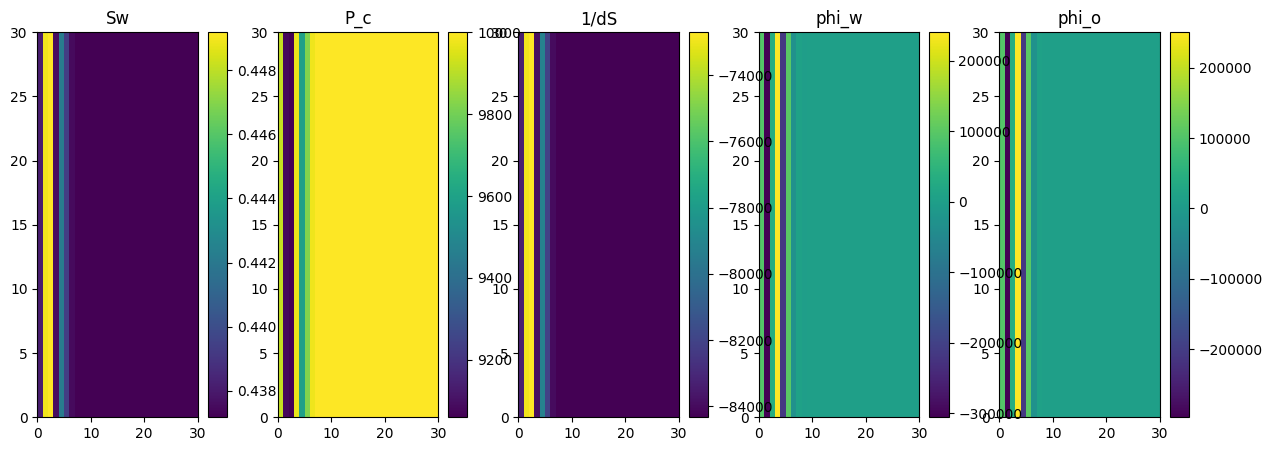

1


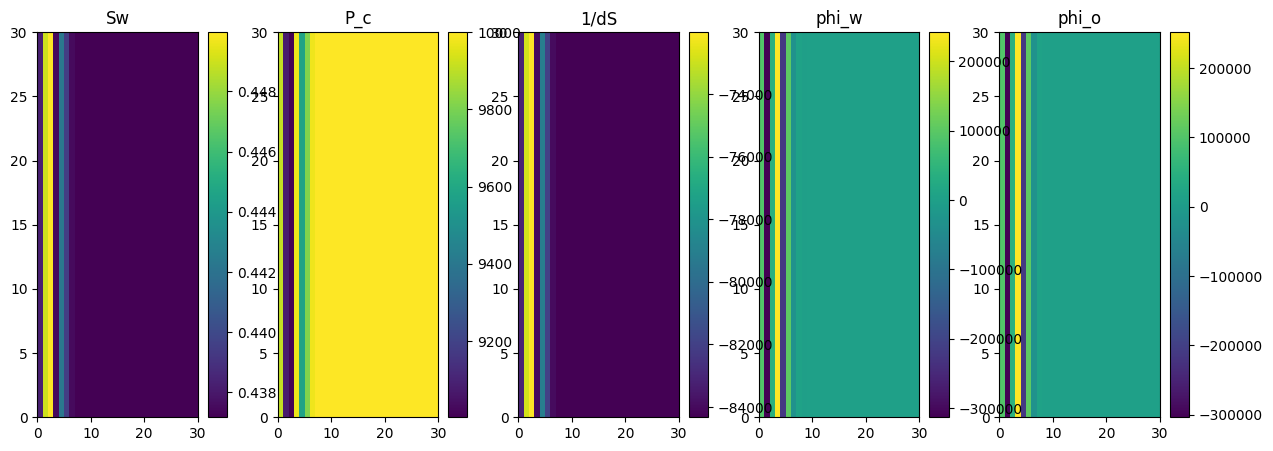

2


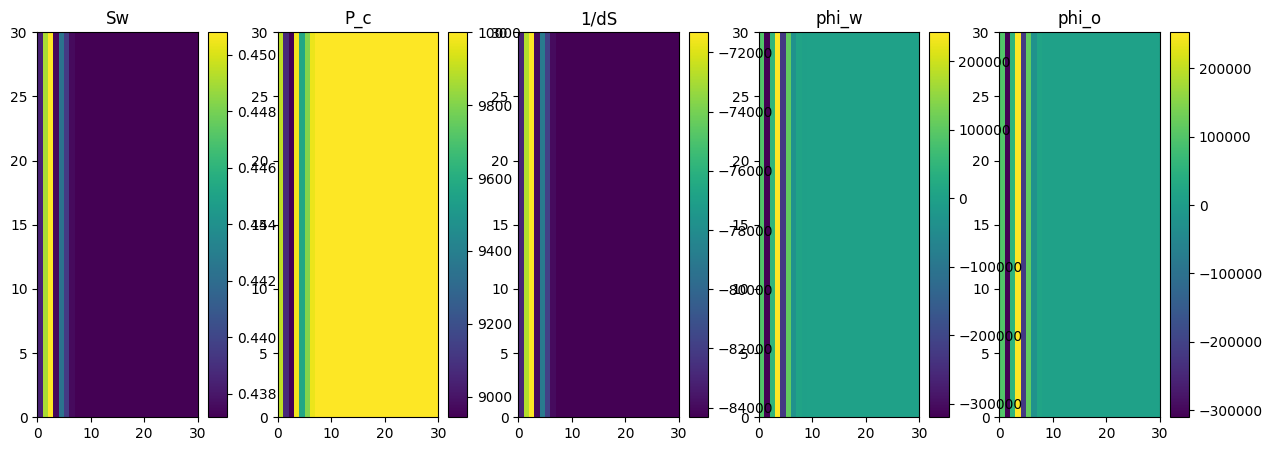

3


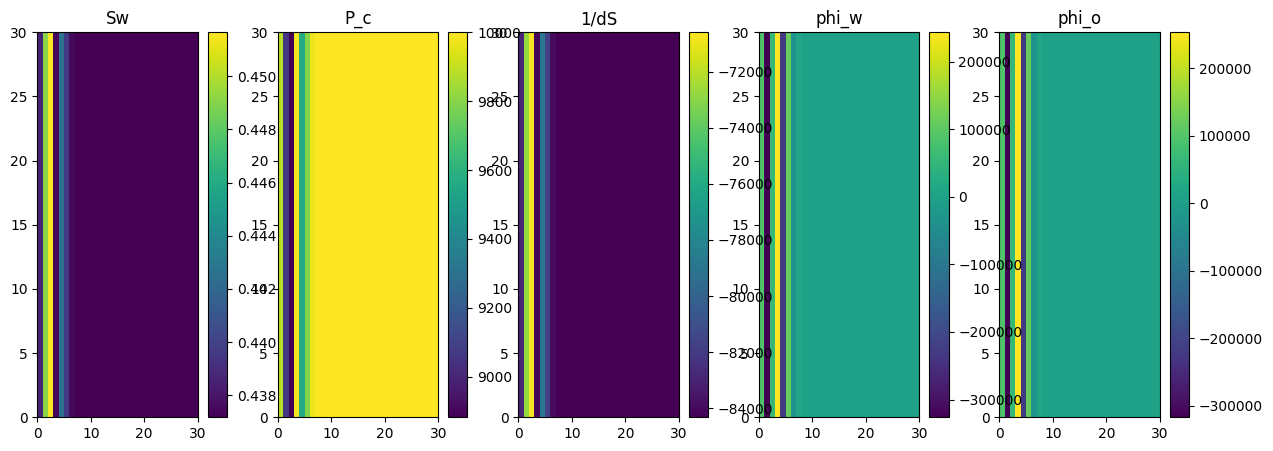

4


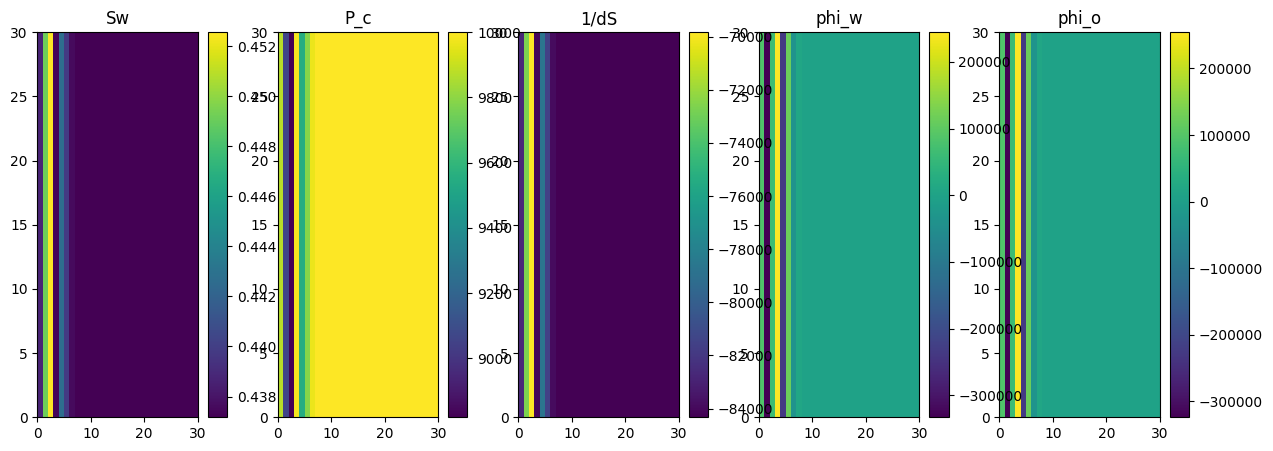

5


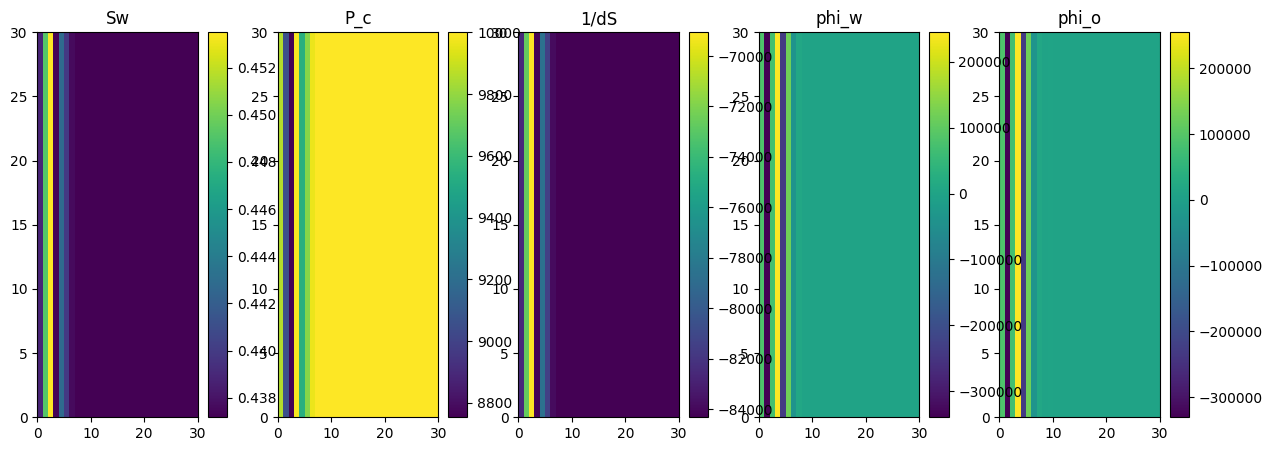

6


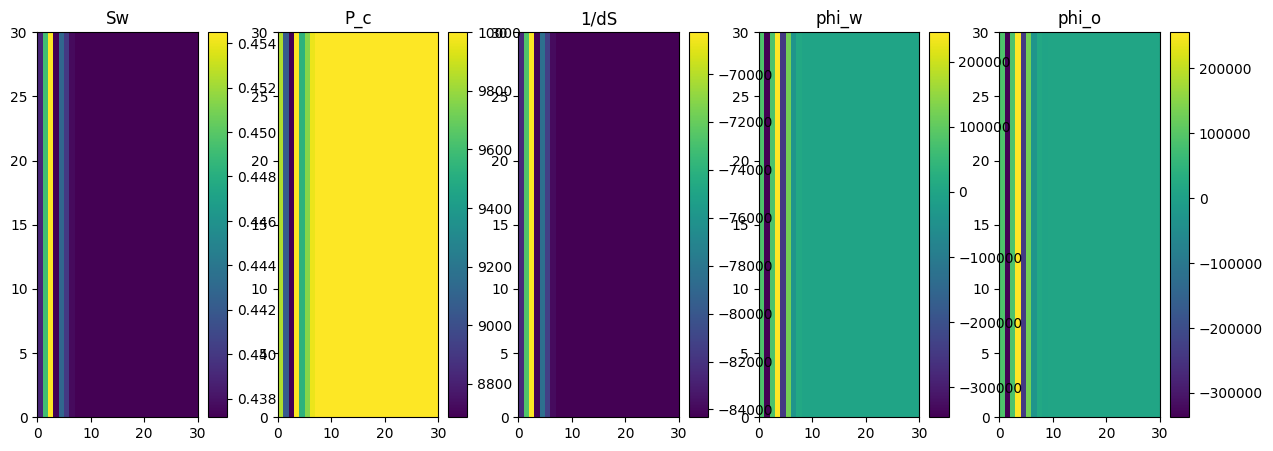

7


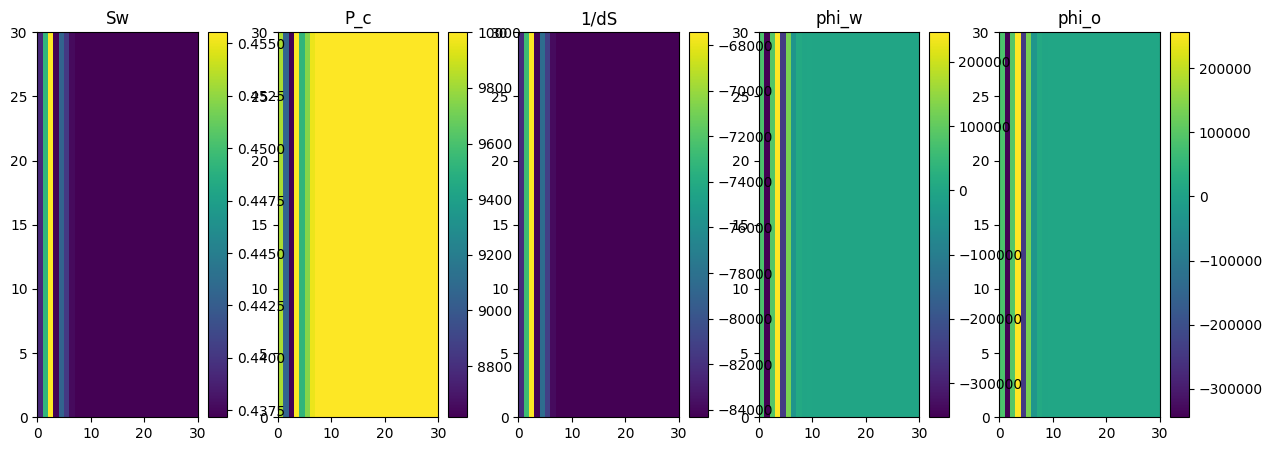

8


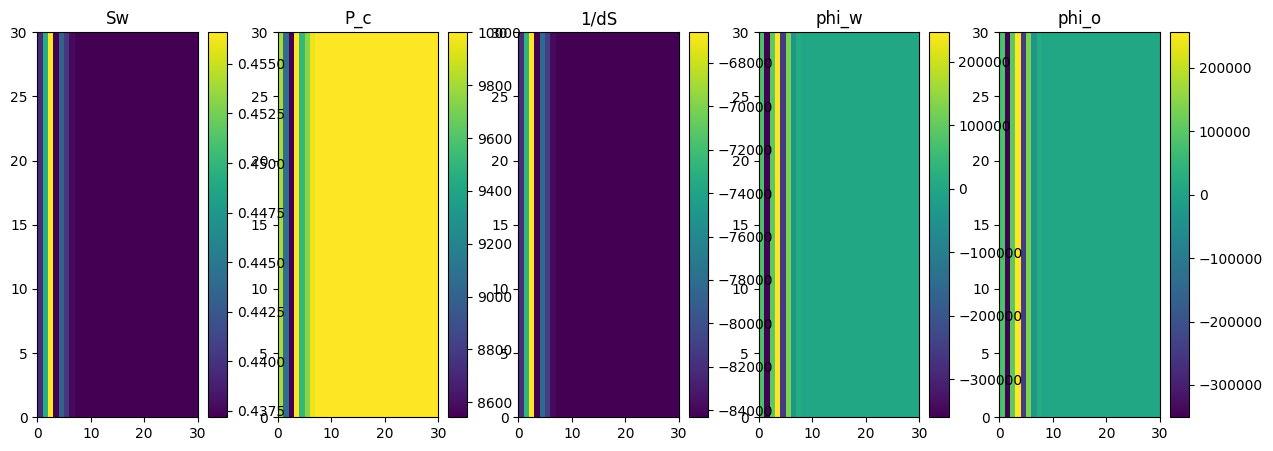

9


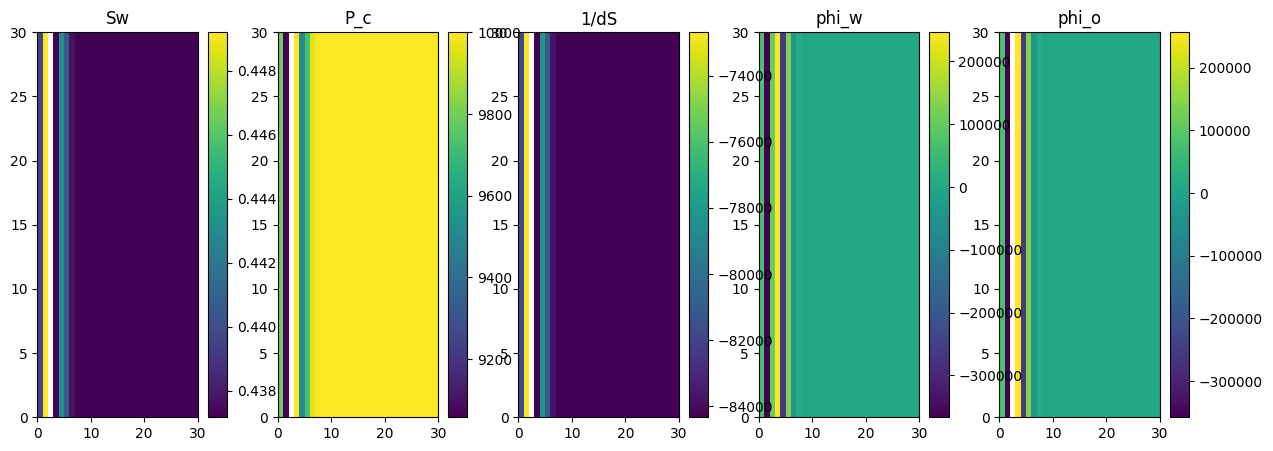

In [631]:

#for f in np.array(phi_t):
#for t,f in enumerate(phi_t[::10]):
for t,f in enumerate(phi_t[-10:]):
    fig,axs=plt.subplots(1,5,figsize=(15,5))
    #axs[0].imshow(Sw_Pc_f(phy.compute_p_c(*f)))
    pcm = axs[0].pcolormesh(Sw_Pc_f(phy.compute_p_c(*f)).numpy("y,x"))
    axs[0].title.set_text("Sw")
    fig.colorbar(pcm,ax=axs[0])
    pcm = axs[1].pcolormesh(phy.compute_p_c(*f).numpy("y,x"))
    axs[1].title.set_text("P_c")
    fig.colorbar(pcm,ax=axs[1])

    pcm = axs[2].pcolormesh(1/dScdPc_f(phy.compute_p_c(*f)).numpy("y,x"))
    axs[2].title.set_text("1/dS")
    fig.colorbar(pcm,ax=axs[2])

    pcm = axs[3].pcolormesh(f[0].numpy("y,x"))
    axs[3].title.set_text("phi_w")
    fig.colorbar(pcm,ax=axs[3])

    pcm = axs[4].pcolormesh(f[1].numpy("y,x"))
    axs[4].title.set_text("phi_o")
    fig.colorbar(pcm,ax=axs[4])


    print(t)
    plt.show()



In [150]:
Sw_Pc_f(phy.compute_p_c(*f)).numpy("x,y")

array([[0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       ...,
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139]], dtype=float32)